# HW02: Tokenization

Remember that these homework work as a completion grade. **You can skip one section without losing credit.**

In [164]:
#Import the AG news dataset (same as hw01)
#Download them from here 
#!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv

import pandas as pd
import nltk
df = pd.read_csv('train.csv')

df.columns = ["label", "title", "lead"]
label_map = {1:"world", 2:"sport", 3:"business", 4:"sci/tech"}
def replace_label(x):
	return label_map[x]
df["label"] = df["label"].apply(replace_label) 
df["text"] = df["title"] + " " + df["lead"]
df.head()

,label,title,lead,text
0,business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...
1,business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...
2,business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...
3,business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new..."
4,business,"Stocks End Up, But Near Year Lows (Reuters)",Reuters - Stocks ended slightly higher on Frid...,"Stocks End Up, But Near Year Lows (Reuters) Re..."


## Preprocess Text

In [165]:
import spacy
dfs = df.sample(50)
nlp = spacy.load('en_core_web_sm')

##TODO use spacy to split the documents in the sampled dataframe (dfs) in sentences and tokens
docs = []
for text in dfs["text"]:
    docs.append(nlp(text))

##TODO print the first sentence of the first document in your sample
print(next(docs[0].sents))


Palace balcony protester removed A Fathers 4 Justice protester dressed as Batman is removed after scaling Buckingham Palace.


In [166]:
##TODO create a new column with tokens in lowercase (x.lower()), without punctuation tokens (x.is_punct), stopwords (x.is_stop), and digits (x.is_digit)

def filterTokens(text):
    doc = nlp(text)
    filtered = []
    for token in doc:
        if not token.is_punct and not token.is_stop and not token.is_digit:
            filtered.append(token.lower_)
    return filtered

dfs["filtered"] = dfs["text"].apply(filterTokens)     
    
##TODO print the tokens (x.lemma_) and the dependency labels (x.dep_ ) of the first sentence of the first document (doc.sents)
for token in next(docs[0].sents):
    print(token.lemma_, token.dep_)

Palace nsubj
balcony compound
protester appos
remove ROOT
a det
Fathers nmod
4 compound
Justice compound
protester dobj
dress acl
as mark
Batman nsubjpass
be auxpass
remove advcl
after prep
scale pcomp
Buckingham compound
Palace dobj
. punct


### Named Entities

Let's compute the ratio of named entities starting with a capital letter, e.g. if we have "University of Chicago" as a NE, "University" and "Chicago" are capitalized, "of" is not, thus the ratio is 2/3.

In [167]:
##TODO print the ratio of tokens being part of a named entity span starting with a capital letter (doc.ents)
ent_len = 0
num_upper = 0
for doc in docs:
    for ent in doc.ents:
        ent_len += len(ent) # count number of tokens in entity
        for token in ent:
            if token.text[0].isupper():
                num_upper += 1
                
print("RATIO: " + str(num_upper / ent_len))

RATIO: 0.6863117870722434


In [168]:
##TODO print the ratio of capitalized tokens not being part of a named entity span (have no token.ent_type_)
# e.g. "The dog barks" = 1/3; 3 tokens, only "The" is capitalized

non_ent_len = 0
num_upper = 0
for doc in docs:
    for token in doc:
        if not token.ent_type_:
            non_ent_len += 1
            if token.text[0].isupper():
                num_upper += 1
print(num_upper / non_ent_len)

0.12663495838287753


In [169]:
##TODO print the ratio of capitalized tokens not being a named entity and not being the first token in a sentence
# e.g. "The dog barks" = 0; 3 tokens, "The" is capitalized but the starting token of a sentence, no other tokens are capitalized.

Give an example of a capitalized token in the data which is neither a named entity nor at the start of a sentence. What could be the reason the token is capitalized (one sentence)?

## Term Frequencies

(-0.5, 1499.5, 1199.5, -0.5)

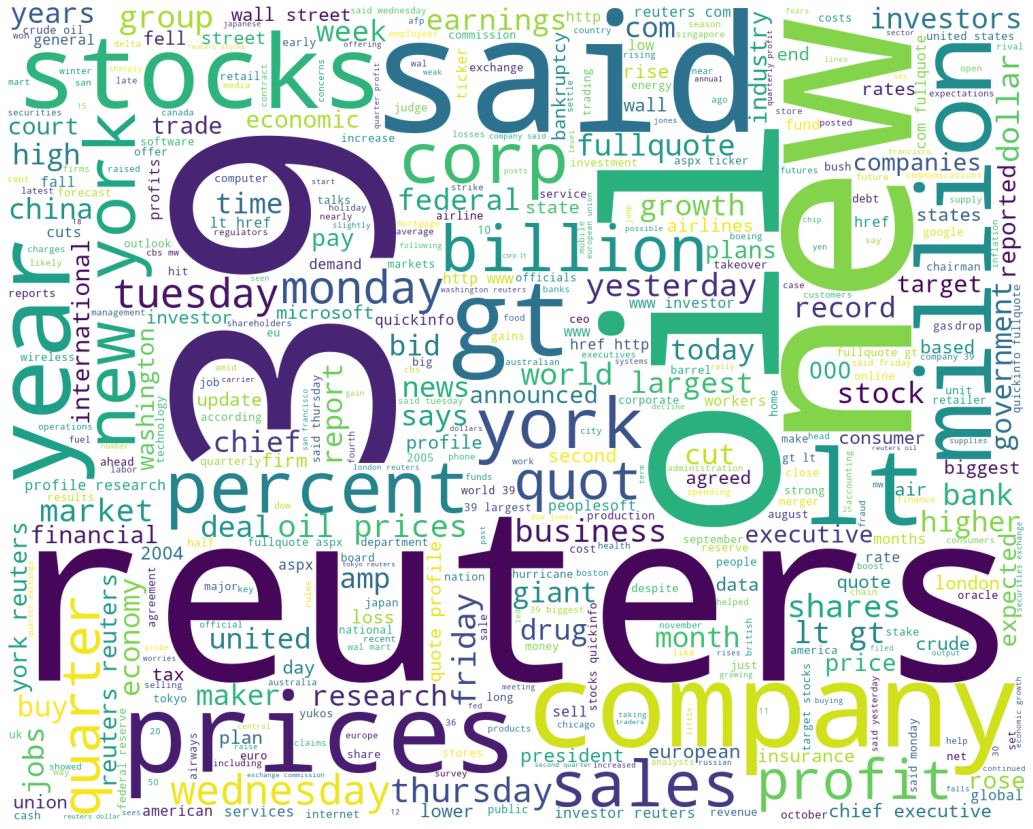

In [170]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=0.01, 
                        max_df=0.9,  
                        max_features=1000,
                        stop_words='english',
                        use_idf=True, # the new piece
                        ngram_range=(1,2))

from wordcloud import WordCloud
import matplotlib.pyplot as plt

##TODO using the whole sample, produce a world cloud with bigrams for label == business using tfidf frequencies
df_business = df.loc[df["label"] == "business"]
tdm = tfidf.fit_transform(df_business["text"])
tfidf_weights = [(word, tdm.getcol(idx).sum()) for word, idx in tfidf.vocabulary_.items()]

w = WordCloud(width=1500, height=1200, mode='RGBA', background_color='white', max_words=2000).fit_words(dict(tfidf_weights))
plt.figure(figsize=(20,15))
plt.imshow(w)
plt.axis('off')

## Supervised Feature Selection

In [171]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

en_stop_words = stopwords.words('english')

def count_non_stop_word(text):
  count = 0
  words = word_tokenize(text)
  for w in words:
    if w not in en_stop_words:
      count += 1
  return count



##TODO compute the number of words per document (excluding stopwords)
##TODO get the most predictive features of the number of words per document using first f_class and then chi2

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tungnguyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Are the results different? What could be a reason for this? 

## Huggingface Tokenizers

In [172]:
# # we use distilbert tokenizer
# !pip install transformers
from transformers import DistilBertTokenizerFast

# let's instantiate a tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
doc = []
tokenized = []
for text in dfs["text"]:
    doc.append(text)
    
for sentence in doc:
    tokenized.append(tokenizer(sentence)["input_ids"])





number_of_unique_token_types = 0
number_of_tokens = 0

decoded = []
for token_list in tokenized:
    number_of_unique_token_types += len(set(token_list))
    number_of_tokens += len(token_list)
    decoded.append(tokenizer.convert_ids_to_tokens(token_list))
    
print(number_of_unique_token_types/number_of_tokens)

decoded
subword_count = 0
for token_list in decoded:
    for token in token_list:
        if token[0] == '#':
            subword_count += 1
            
print("Subword count: " + str(subword_count))
            

##TODO tokenize the sentences in the sampled dataframe (dfs) using the DisilBertTokenizer
##TODO what is the type/token ratio from this tokenizer (number_of_unqiue_token_types/number_of_tokens)?
##TODO what is the amount of subword tokens returned by the huggingface tokenizer? hint: each subword token starts with "#"



0.7584415584415585
Subword count: 192


# Parsing

In [173]:
import pandas as pd
import nltk
df = pd.read_csv('train.csv')

df.columns = ["label", "title", "lead"]
label_map = {1:"world", 2:"sport", 3:"business", 4:"sci/tech"}
def replace_label(x):
	return label_map[x]
df["label"] = df["label"].apply(replace_label) 
df["text"] = df["title"] + " " + df["lead"]
df = df.sample(n=10000) # # only use 10K datapoints
df.head()

,label,title,lead,text
65377,world,Spain Disrupts Terror Plot,Spanish authorities said Tuesday they disrupte...,Spain Disrupts Terror Plot Spanish authorities...
118193,world,Praise the lords,"The law lords have produced a historic, landma...",Praise the lords The law lords have produced a...
112627,business,"Consumers Cheer Up, Budget Deficit Swells",CHICAGO (Reuters) - U.S. consumers' mood brig...,"Consumers Cheer Up, Budget Deficit Swells CHI..."
51588,business,Stewart case ink expert found not guilty of lying,An ink expert who testified for the government...,Stewart case ink expert found not guilty of ly...
33128,world,Far-Right Surge in East Alarms Mainstream Germany,Germany faced a surge of far-right parties in ...,Far-Right Surge in East Alarms Mainstream Germ...


In [174]:
import spacy
nlp = spacy.load('en_core_web_sm')
docs = []
for text in dfs["text"]:
    docs.append(nlp(text))
#TODO preprocess the corpus using spacy


### Information Extraction

In [175]:
def extract_subject_verb_pairs(sent):
    subjs = [w for w in sent if w.dep_ == "nsubj"]
    pairs = [(w.lemma_.lower(), w.head.lemma_.lower()) for w in subjs]
    return pairs
##TODO extract the subject-verbs pairs and print the result for the second document

subject_verbs_pairs = []
for doc in docs:
    for sent in doc.sents:
        subject_verbs_pairs.append(extract_subject_verb_pairs(sent))

print(subject_verbs_pairs[1])
from collections import Counter
counter = Counter()

for pairs in subject_verbs_pairs:
    for pair in pairs:
        counter[pair] += 1
counter.most_common(10)


##TODO create a list ranking the most common pairs and print the first 10 items

[('agent', 'fight'), ('association', 'challenge'), ('that', 'sour')]


[(('beckham', 'play'), 2),
 (('it', 'provide'), 2),
 (('police', 'confirm'), 2),
 (('which', 'be'), 2),
 (('it', 'be'), 2),
 (('who', 'lead'), 2),
 (('election', 'go'), 2),
 (('palace', 'remove'), 1),
 (('agent', 'fight'), 1),
 (('association', 'challenge'), 1)]

In [176]:
##TODO do the same for verbs-object pairs ('dobj')
##TODO create a list ranking the most common pairs and print the first 10 items
def extract_verbs_object_pairs(sent):
    obj = [w for w in sent if w.dep_ == "dobj"]
    pairs = [(w.lemma_.lower(), w.head.lemma_.lower()) for w in obj]
    return pairs


verbs_object_pairs = []
for doc in docs:
    for sent in doc.sents:
        verbs_object_pairs.append(extract_verbs_object_pairs(sent))

print(verbs_object_pairs[1])
from collections import Counter
counter = Counter()

for pairs in verbs_object_pairs:
    for pair in pairs:
        counter[pair] += 1
counter.most_common(10)

[('fee', 'fight'), ('inc.', 'challenge'), ('plan', 'challenge'), ('fee', 'pass'), ('agent', 'travel')]


[(('people', 'kill'), 2),
 (('inc.', 'acquire'), 2),
 (('it', 'do'), 2),
 (('protester', 'remove'), 1),
 (('palace', 'scale'), 1),
 (('fee', 'fight'), 1),
 (('inc.', 'challenge'), 1),
 (('plan', 'challenge'), 1),
 (('fee', 'pass'), 1),
 (('agent', 'travel'), 1)]

In [177]:
##TODO do the same for adjectives-nouns pairs ('amod')
##TODO create a list ranking the most common pairs and print the first 10 items
def extract_adjectives_nouns_pairs(sent):
    mod = [w for w in sent if w.dep_ == "amod"]
    pairs = [(w.lemma_.lower(), w.head.lemma_.lower()) for w in mod]
    return pairs


adjectives_nouns_pairs = []
for doc in docs:
    for sent in doc.sents:
        adjectives_nouns_pairs.append(extract_adjectives_nouns_pairs(sent))

print(adjectives_nouns_pairs[1])
from collections import Counter
counter = Counter()

for pairs in adjectives_nouns_pairs:
    for pair in pairs:
        counter[pair] += 1
counter.most_common(10)

[('new', 'fee'), ('next', 'week')]


[(('new', 'fee'), 1),
 (('next', 'week'), 1),
 (('strong', 'earthquake'), 1),
 (('jolt', 'japan'), 1),
 (('northern', 'japan'), 1),
 (('late', 'aftershock'), 1),
 (('deadly', 'tremor'), 1),
 (('last', 'month'), 1),
 (('makeshift', 'shelter'), 1),
 (('algerian', 'medea'), 1)]

### Exploring cross label dependencies

In [178]:
##TODO extract all the subject-verbs and verbs-object pairs for the verb "rise"
def extract_subject_verb_pairs_2(sent):
    subjs = [w for w in sent if w.dep_ == "nsubj" and w.head.lemma_.lower() == "rise"]
    pairs = [(w.lemma_.lower(), w.head.lemma_.lower()) for w in subjs]
    return pairs
def extract_verbs_object_pairs_2(sent):
    obj = [w for w in sent if w.dep_ == "dobj" and w.head.lemma_.lower() == "rise"]
    pairs = [(w.lemma_.lower(), w.head.lemma_.lower()) for w in obj]
    return pairs

subject_verbs_pairs = []
for doc in docs:
    for sent in doc.sents:
        subject_verbs_pairs.append(extract_subject_verb_pairs_2(sent))

        
verbs_object_pairs = []
for doc in docs:
    for sent in doc.sents:
        subject_verbs_pairs.append(extract_verbs_object_pairs_2(sent))

In [179]:
##TODO for each label create a list ranking the most common subject-verbs pairs and one for the most common verbs-object pairs
##TODO print the 10 most common pairs for each of the two lists for the labels "world" and "sci/tech"